In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

class SlotsEnvironment():
    def __init__(self, current_money):
        self.action_space = [0, 1, 2, 3, 4] #Defines our 5 machines
        self.current_money = current_money #Tracks the current money
        self.last_two_choices = [random.choice(self.action_space), random.choice(self.action_space)] #Define 2 random actions 
        self.consecutive_choice_count = 0  #Initialise the counter for the choice of a consecutive machine, we will punish the agent harder if it keeps choosing the same machine
        self.jackpot_active = False  #Tracks the jackpot round (5% chance and higher gains)
    
    
    def number_of_states(self):
        return 101 * len(self.action_space) ** 2 #Number of different states
    
    def get_state(self):

        state = self.current_money
        state += 101 * (self.last_two_choices[0] + 5 * self.last_two_choices[1]) #Based on the money ranging from 1 to 99 and the choice of machines from 0 to 4
        return state   
    
     
    def do_action(self, action):
        done = False
        reward = 0

        if self.current_money <= 2:
            done = True
            return -100, done
        elif self.current_money >= 100:
            done = True
            return 100, done
        
        if random.random() < 0.05:  #5% chances for the jackpot
            self.jackpot_active = not self.jackpot_active

        
        if action == self.last_two_choices[1]: 
            self.consecutive_choice_count += 1 #Adds up to the count if the machine played is the same as previously
        else:
            self.consecutive_choice_count = 1 #Otherwise reset the count

        
        base_reward = -3 if self.last_two_choices[0] != action else 3 #Update our reward given the scenario
        reward = base_reward * (2 if self.jackpot_active else 1) #Gives 2x the rewards if there is the jackpot

        
        if self.consecutive_choice_count > 3: 
            reward -= 5  #-5 penalty if the agent plays the same machine more than 3 times in a row

        
        self.current_money += reward #Update money based on the reward
        if self.current_money <= 0:
            self.current_money = 0
            done = True
            reward = -100 #-100 reward if the agent goes out of money
        elif self.current_money >= 100:
            done = True
            reward = 100 #+100 reward if the money goes over 100

        
        self.last_two_choices.pop(0) #Update last two choices
        self.last_two_choices.append(action)

        return reward, done
    
    def reset(self):
        self.current_money = 10  #Gives the agent 10 money when reseted
        self.last_two_choices = [random.choice(self.action_space), random.choice(self.action_space)]
        self.consecutive_choice_count = 0
        self.jackpot_active = False
        return self.get_state()

We first define a greedy policy with random parameters

In [2]:
#Q learning function
def q_learning_greedy(env, episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.1):
    number_of_states = env.number_of_states()
    number_of_actions = len(env.action_space)
    q_table = np.zeros((number_of_states, number_of_actions))
    episode_rewards = [] #Empty list to store the rewards for each episode, for plotting
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0 #Otherwise I get variable referenced before assignment
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.action_space)  #exploration
            else:
                action = np.argmax(q_table[state])  #Greedy policy

            reward, done = env.do_action(action)
            total_reward += reward #Define the total reward as the sum of all the rewards, that we will append later on
            new_state = env.get_state()
            future_rewards = np.max(q_table[new_state])
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (reward + gamma * future_rewards)
            state = new_state
        
        episode_rewards.append(total_reward)

    return q_table, episode_rewards

#Use the function
current_money = 5  #Starting with 5 dollars
env = SlotsEnvironment(current_money) #Set up the environment as defined above
q_table, episode_rewards = q_learning_greedy(env)
print("Q-table for Epsilon greedy policy:")
print(q_table)

Q-table for learned policy:
[[  0.      0.      0.      0.      0.   ]
 [-29.701 -29.701 -29.701 -29.701 -29.701]
 [-19.9   -19.    -19.9   -19.9   -10.   ]
 ...
 [  0.      0.      0.      0.      0.   ]
 [  0.      0.      0.      0.      0.   ]
 [  0.      0.      0.      0.      0.   ]]


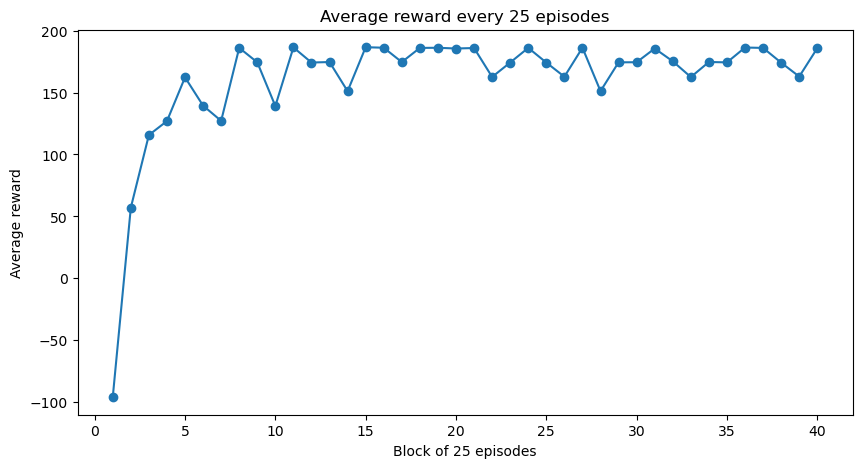

In [3]:
#Reward is almost binary so we will compute the average reward every 25 episodes, to smoothe it out

def plot_reward_per_episode(rewards, block_size=25, label= None):
    number_blocks = len(rewards) // block_size #Define the overall number of blocks
    mean_reward = []

    for i in range(number_blocks):
        block_reward = np.mean(rewards[i * block_size:(i+1) * block_size])
        mean_reward.append(block_reward)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, number_blocks + 1), mean_reward, marker='o', linestyle='-')
    plt.title('Average reward every 25 episodes')
    plt.xlabel('Block of 25 episodes')
    plt.ylabel('Average reward')
    
    plt.show()

#Use the function
current_money = 5  #Starting with 5 dollars
env = SlotsEnvironment(current_money) #Set up the environment as defined above
q_table, episode_rewards = q_learning_greedy(env, episodes=1000)
plot_reward_per_episode(episode_rewards, block_size=25) #Plot

We will now define the grid search and look for a potential better set of parameters, as well as trying out different policies

In [4]:
import pandas as pd

alpha_values = [0.1, 0.5, 0.9] #Different learning rate values for grid search
gamma_values = [0.8, 0.9, 0.95, 0.99] #Different discount factor values for grid search
epsilon_values = [0.1, 0.2, 0.3] #Different probabilities for random moves

df = pd.DataFrame(columns=['Alpha', 'Gamma', 'Epsilon', 'Mean Reward']) #create a df in which we will store the results

#grid search
for alpha in alpha_values:
    for gamma in gamma_values:
        for epsilon in epsilon_values:
            #q_learning
            _, episode_rewards = q_learning_greedy(env, episodes=5000, alpha=alpha, gamma=gamma, epsilon=epsilon)
            #mean rewards after 5000 episodes
            mean_reward = np.mean(episode_rewards)
            
            #create a second dataframe for each row, containing the values
            rows =  pd.DataFrame({
                'Alpha': [alpha],
                'Gamma': [gamma],
                'Epsilon': [epsilon],
                'Mean Reward': [mean_reward]
            })

            df = pd.concat([df,rows], ignore_index=True)

# Print the DataFrame to see the results
print(df)


    Alpha  Gamma  Epsilon  Mean Reward
0     0.1   0.80      0.1     174.8606
1     0.1   0.80      0.2     163.7184
2     0.1   0.80      0.3     143.0344
3     0.1   0.90      0.1     174.0802
4     0.1   0.90      0.2     163.2934
5     0.1   0.90      0.3     140.0882
6     0.1   0.95      0.1     173.2674
7     0.1   0.95      0.2     163.3444
8     0.1   0.95      0.3     136.7468
9     0.1   0.99      0.1     174.0134
10    0.1   0.99      0.2     159.7596
11    0.1   0.99      0.3     132.4558
12    0.5   0.80      0.1     174.8642
13    0.5   0.80      0.2     163.8634
14    0.5   0.80      0.3     133.4294
15    0.5   0.90      0.1     174.4066
16    0.5   0.90      0.2     154.7760
17    0.5   0.90      0.3     119.6330
18    0.5   0.95      0.1     170.5852
19    0.5   0.95      0.2     146.2954
20    0.5   0.95      0.3      87.8676
21    0.5   0.99      0.1     166.9422
22    0.5   0.99      0.2     139.2820
23    0.5   0.99      0.3      77.0818
24    0.9   0.80      0.1

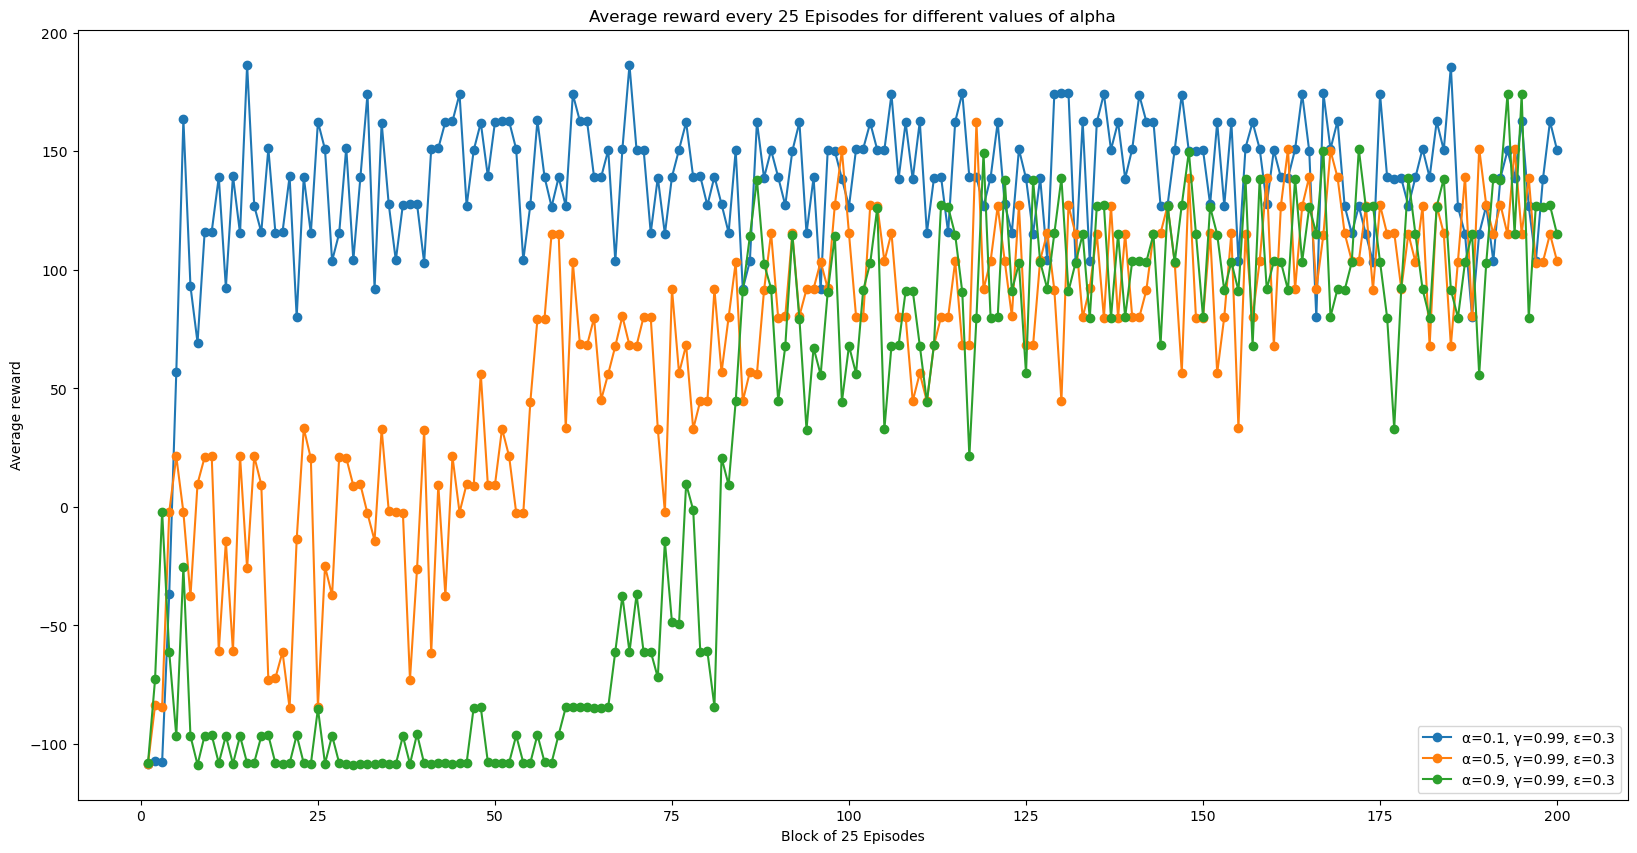

In [5]:
alpha_values = [0.1, 0.5, 0.9] #Different learning rate values for grid search
gamma_values = [0.8, 0.9, 0.95, 0.99] #Different discount factor values for grid search
epsilon_values = [0.1, 0.2, 0.3] #Different probabilities for random moves

plt.figure(figsize=(20,10))

for alpha in alpha_values:
    #compute the qlearning function defined above
    _, episode_rewards = q_learning_greedy(env, episodes=5000, alpha=alpha, gamma=gamma, epsilon=epsilon)
    #Get the mean reward block by block 
    block_size = 25
    number_blocks = len(episode_rewards) // block_size
    mean_rewards = []
    for i in range(number_blocks):
        block_reward = np.mean(episode_rewards[i * block_size:(i + 1) * block_size])
        mean_rewards.append(block_reward)
            
    #plot the reward for each block
    plt.plot(range(1, number_blocks + 1), mean_rewards, marker='o', linestyle='-', label=f'α={alpha}, γ={gamma}, ε={epsilon}') #Used a LLM for this plot because i couldn't find the greek letters properly

#plot
plt.title('Average reward every 25 Episodes for different values of alpha')
plt.xlabel('Block of 25 Episodes')
plt.ylabel('Average reward')
plt.legend()
plt.show()

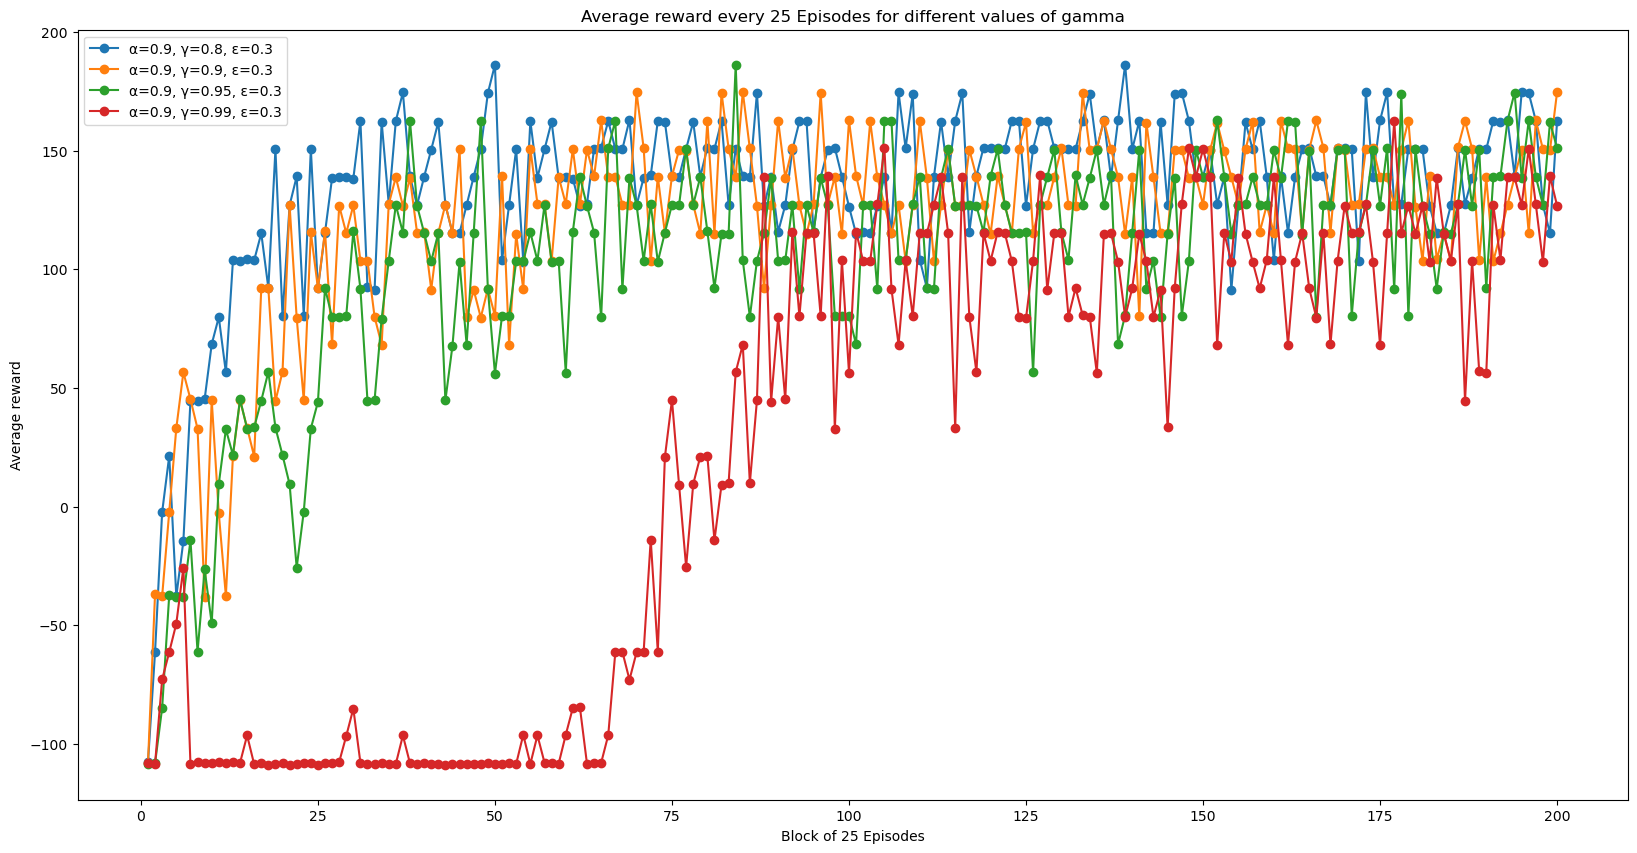

In [6]:
plt.figure(figsize=(20,10))

for gamma in gamma_values:
    #compute the qlearning function defined above
    _, episode_rewards = q_learning_greedy(env, episodes=5000, alpha=alpha, gamma=gamma, epsilon=epsilon)
    #Get the mean reward block by block 
    block_size = 25
    number_blocks = len(episode_rewards) // block_size
    mean_rewards = []
    for i in range(number_blocks):
        block_reward = np.mean(episode_rewards[i * block_size:(i + 1) * block_size])
        mean_rewards.append(block_reward)
            
    #plot the reward for each block
    plt.plot(range(1, number_blocks + 1), mean_rewards, marker='o', linestyle='-', label=f'α={alpha}, γ={gamma}, ε={epsilon}') #Used a LLM for this plot because i couldn't find the greek letters properly

#plot
plt.title('Average reward every 25 Episodes for different values of gamma')
plt.xlabel('Block of 25 Episodes')
plt.ylabel('Average reward')
plt.legend()
plt.show()

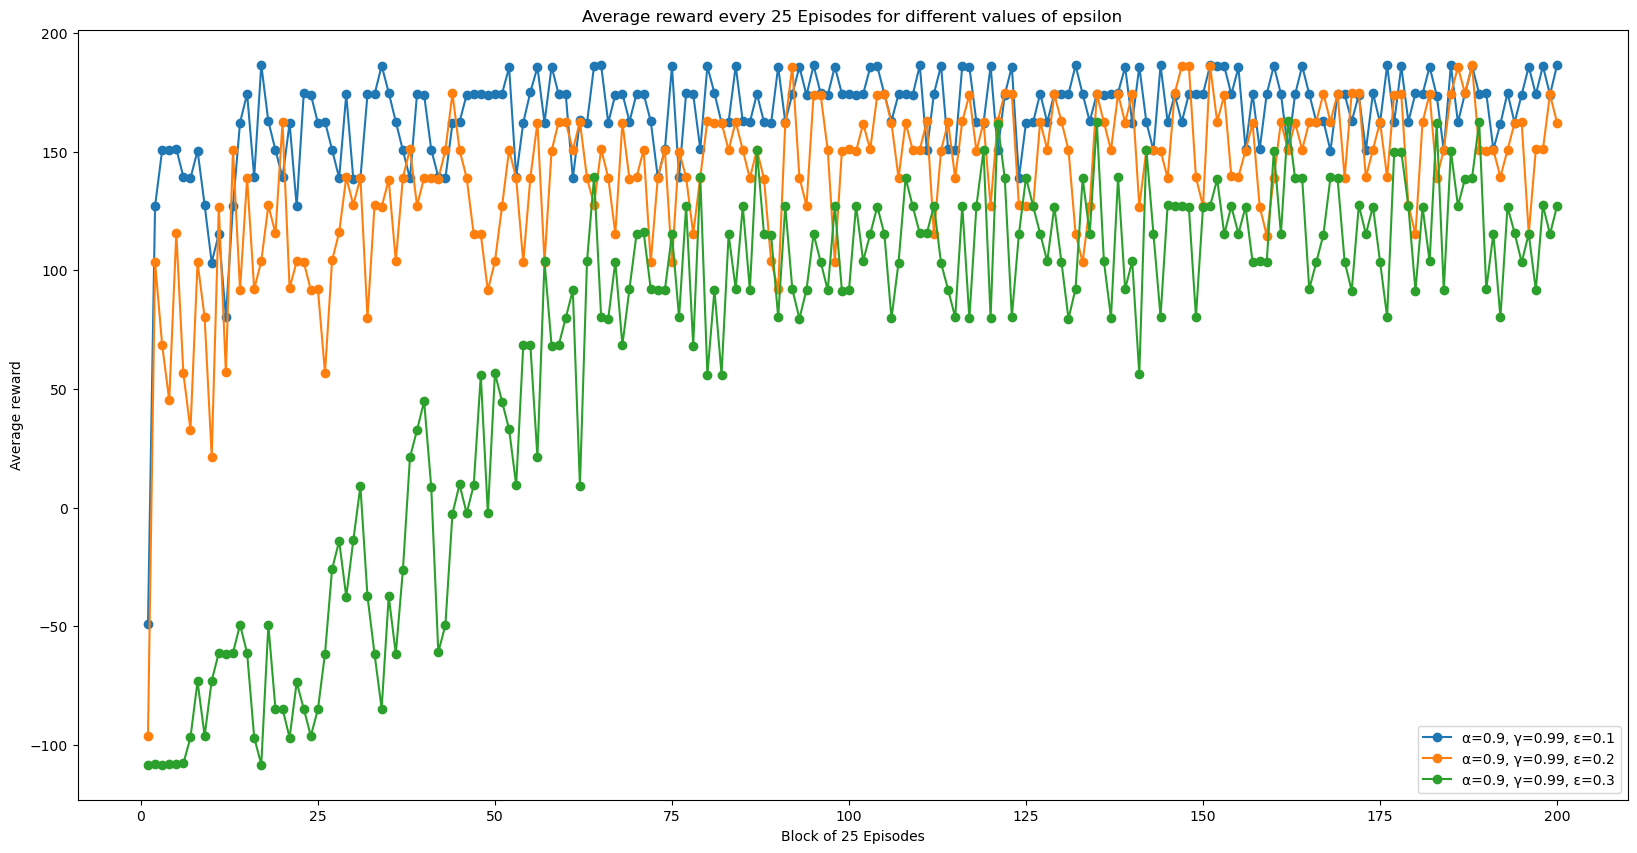

In [7]:
plt.figure(figsize=(20,10))

for epsilon in epsilon_values:
    #compute the qlearning function defined above
    _, episode_rewards = q_learning_greedy(env, episodes=5000, alpha=alpha, gamma=gamma, epsilon=epsilon)
    #Get the mean reward block by block 
    block_size = 25
    number_blocks = len(episode_rewards) // block_size
    mean_rewards = []
    for i in range(number_blocks):
        block_reward = np.mean(episode_rewards[i * block_size:(i + 1) * block_size])
        mean_rewards.append(block_reward)
            
    #plot the reward for each block
    plt.plot(range(1, number_blocks + 1), mean_rewards, marker='o', linestyle='-', label=f'α={alpha}, γ={gamma}, ε={epsilon}') #Used a LLM for this plot because i couldn't find the greek letters properly

#plot
plt.title('Average reward every 25 Episodes for different values of epsilon')
plt.xlabel('Block of 25 Episodes')
plt.ylabel('Average reward')
plt.legend()
plt.show()

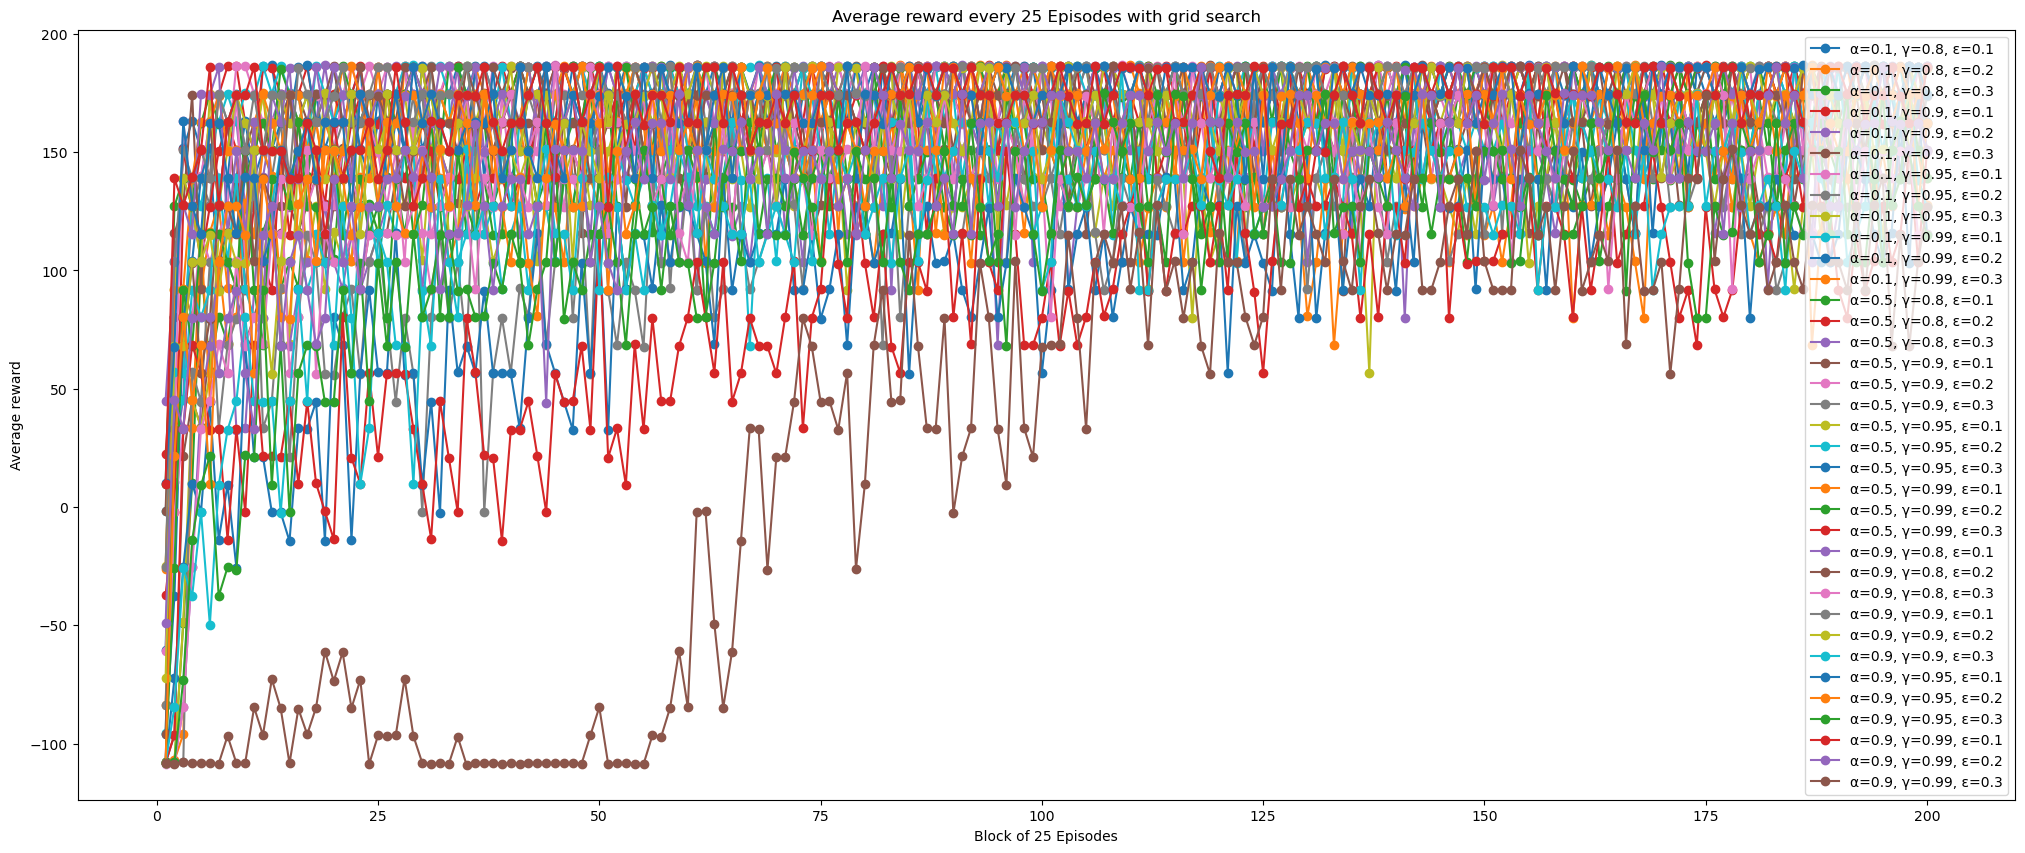

In [8]:
plt.figure(figsize=(25,10))

for alpha in alpha_values:
    for gamma in gamma_values:
        for epsilon in epsilon_values:
            #compute the qlearning function defined above
            _, episode_rewards = q_learning_greedy(env, episodes=5000, alpha=alpha, gamma=gamma, epsilon=epsilon)
            #Get the mean reward block by block 
            block_size = 25
            number_blocks = len(episode_rewards) // block_size
            mean_rewards = []
            for i in range(number_blocks):
                block_reward = np.mean(episode_rewards[i * block_size:(i + 1) * block_size])
                mean_rewards.append(block_reward)
            
            #plot the reward for each block
            plt.plot(range(1, number_blocks + 1), mean_rewards, marker='o', linestyle='-', label=f'α={alpha}, γ={gamma}, ε={epsilon}') #Used a LLM for this plot because i couldn't find the greek letters properly

#plot
plt.title('Average reward every 25 Episodes with grid search')
plt.xlabel('Block of 25 Episodes')
plt.ylabel('Average reward')
plt.legend()
plt.show()

In [34]:
def softmax(q_values, tau):
    q_values_stable = q_values - np.max(q_values)
    preferences = np.exp(q_values_stable / tau) #Formula
    probabilities = preferences / np.sum(preferences) #Normalize to obtain the probabilities
    return probabilities

def q_learning_softmax(env, episodes=5000, alpha=0.1, gamma=0.9, tau=0.1):
    number_of_states = env.number_of_states()
    number_of_actions = len(env.action_space)
    q_table = np.zeros((number_of_states, number_of_actions))
    episode_rewards = [] #Empty list to store the rewards for each episode, for plotting
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0 #Otherwise I get variable referenced before assignment
        while not done:
            action = np.random.choice(env.action_space, p=softmax(q_table[state], tau))#softmax policy
            reward, done = env.do_action(action)
            total_reward += reward #Define the total reward as the sum of all the rewards, that we will append later on
            new_state = env.get_state()
            future_rewards = np.max(q_table[new_state])
            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (reward + gamma * future_rewards)
            state = new_state
        
        episode_rewards.append(total_reward)

    return q_table, episode_rewards

#Use the function
current_money = 5  #Starting with 5 dollars
env = SlotsEnvironment(current_money) #Set up the environment as defined above
q_table, episode_rewards = q_learning_softmax(env)
print("Q-table for Softmax policy:")
print(q_table)
    

Q-table for Softmax policy:
[[  0.   0.   0.   0.   0.]
 [-10.   0.   0. -10.   0.]
 [-10.   0.   0. -10.   0.]
 ...
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


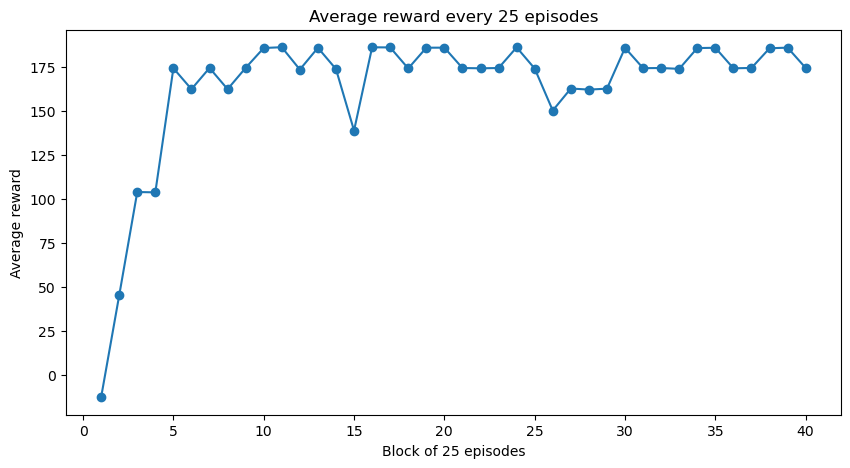

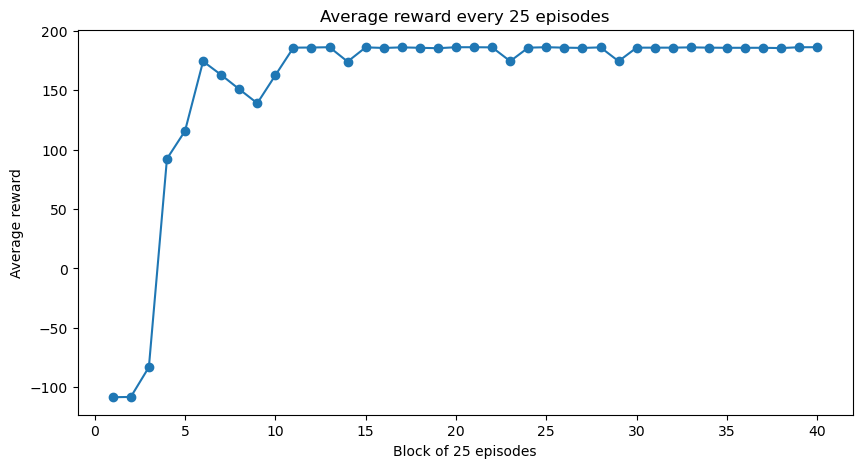

In [31]:
current_money = 5
env = SlotsEnvironment(current_money)

q_table_greedy, episode_rewards_greedy = q_learning_greedy(env,episodes=1000)
q_table_softmax, episode_rewards_softmax = q_learning_softmax(env,episodes=1000)

plot_reward_per_episode(episode_rewards_greedy,block_size=25)
plot_reward_per_episode(episode_rewards_softmax, block_size=25)#plot

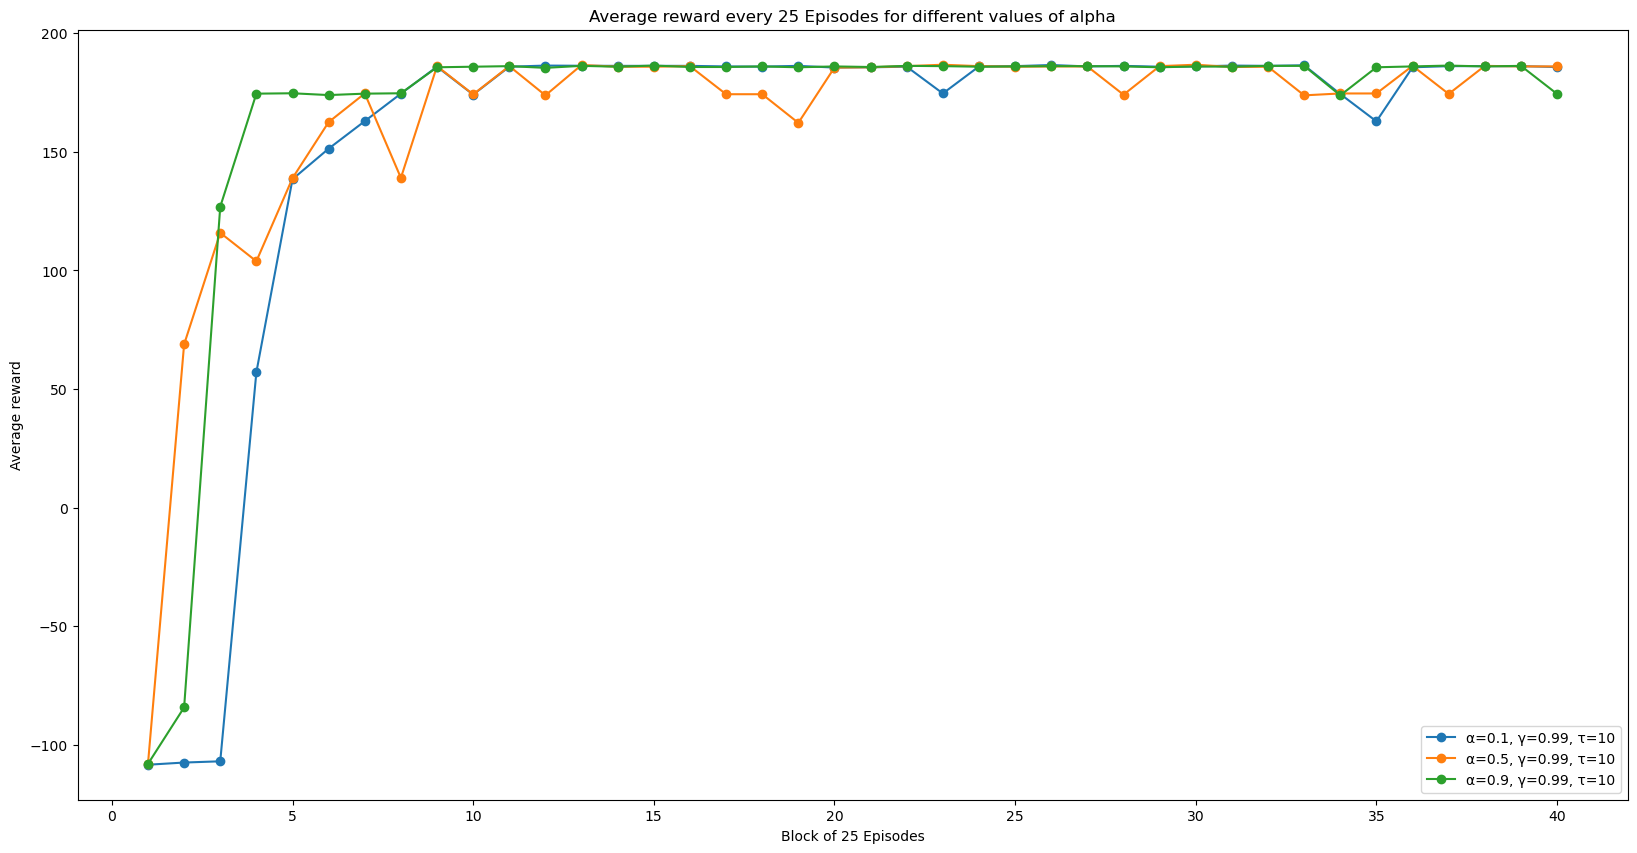

In [41]:
alpha_values = [0.1, 0.5, 0.9] #Different learning rate values for grid search
gamma_values = [0.8, 0.9, 0.95, 0.99] #Different discount factor values for grid search
tau_values = [0.01, 0.1, 1, 10] #Different probabilities for random moves

plt.figure(figsize=(20,10))

for alpha in alpha_values:
    #compute the qlearning function defined above
    _, episode_rewards = q_learning_softmax(env, episodes=1000, alpha=alpha, gamma=gamma, tau=0.1)
    #Get the mean reward block by block 
    block_size = 25
    number_blocks = len(episode_rewards) // block_size
    mean_rewards = []
    for i in range(number_blocks):
        block_reward = np.mean(episode_rewards[i * block_size:(i + 1) * block_size])
        mean_rewards.append(block_reward)
            
    #plot the reward for each block
    plt.plot(range(1, number_blocks + 1), mean_rewards, marker='o', linestyle='-', label=f'α={alpha}, γ={gamma}, τ={tau}') #Used a LLM for this plot because i couldn't find the greek letters properly

#plot
plt.title('Average reward every 25 Episodes for different values of alpha')
plt.xlabel('Block of 25 Episodes')
plt.ylabel('Average reward')
plt.legend()
plt.show()

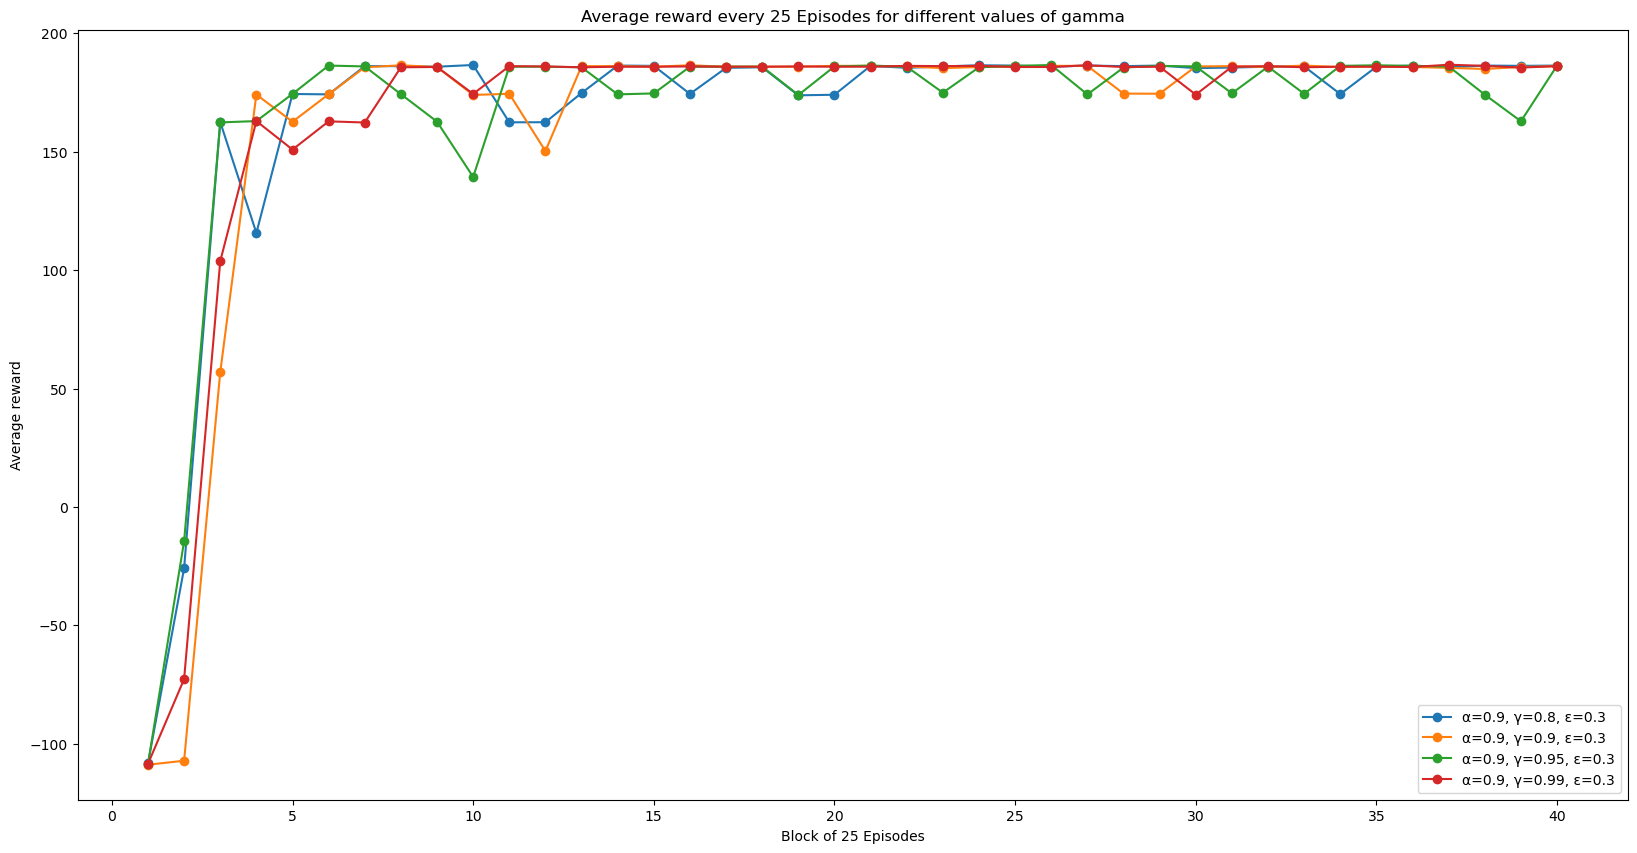

In [40]:
plt.figure(figsize=(20,10))

for gamma in gamma_values:
    #compute the qlearning function defined above
    _, episode_rewards = q_learning_softmax(env, episodes=1000, alpha=alpha, gamma=gamma, tau=0.1)
    #Get the mean reward block by block 
    block_size = 25
    number_blocks = len(episode_rewards) // block_size
    mean_rewards = []
    for i in range(number_blocks):
        block_reward = np.mean(episode_rewards[i * block_size:(i + 1) * block_size])
        mean_rewards.append(block_reward)
            
    #plot the reward for each block
    plt.plot(range(1, number_blocks + 1), mean_rewards, marker='o', linestyle='-', label=f'α={alpha}, γ={gamma}, τ={tau}') #Used a LLM for this plot because i couldn't find the greek letters properly

#plot
plt.title('Average reward every 25 Episodes for different values of gamma')
plt.xlabel('Block of 25 Episodes')
plt.ylabel('Average reward')
plt.legend()
plt.show()

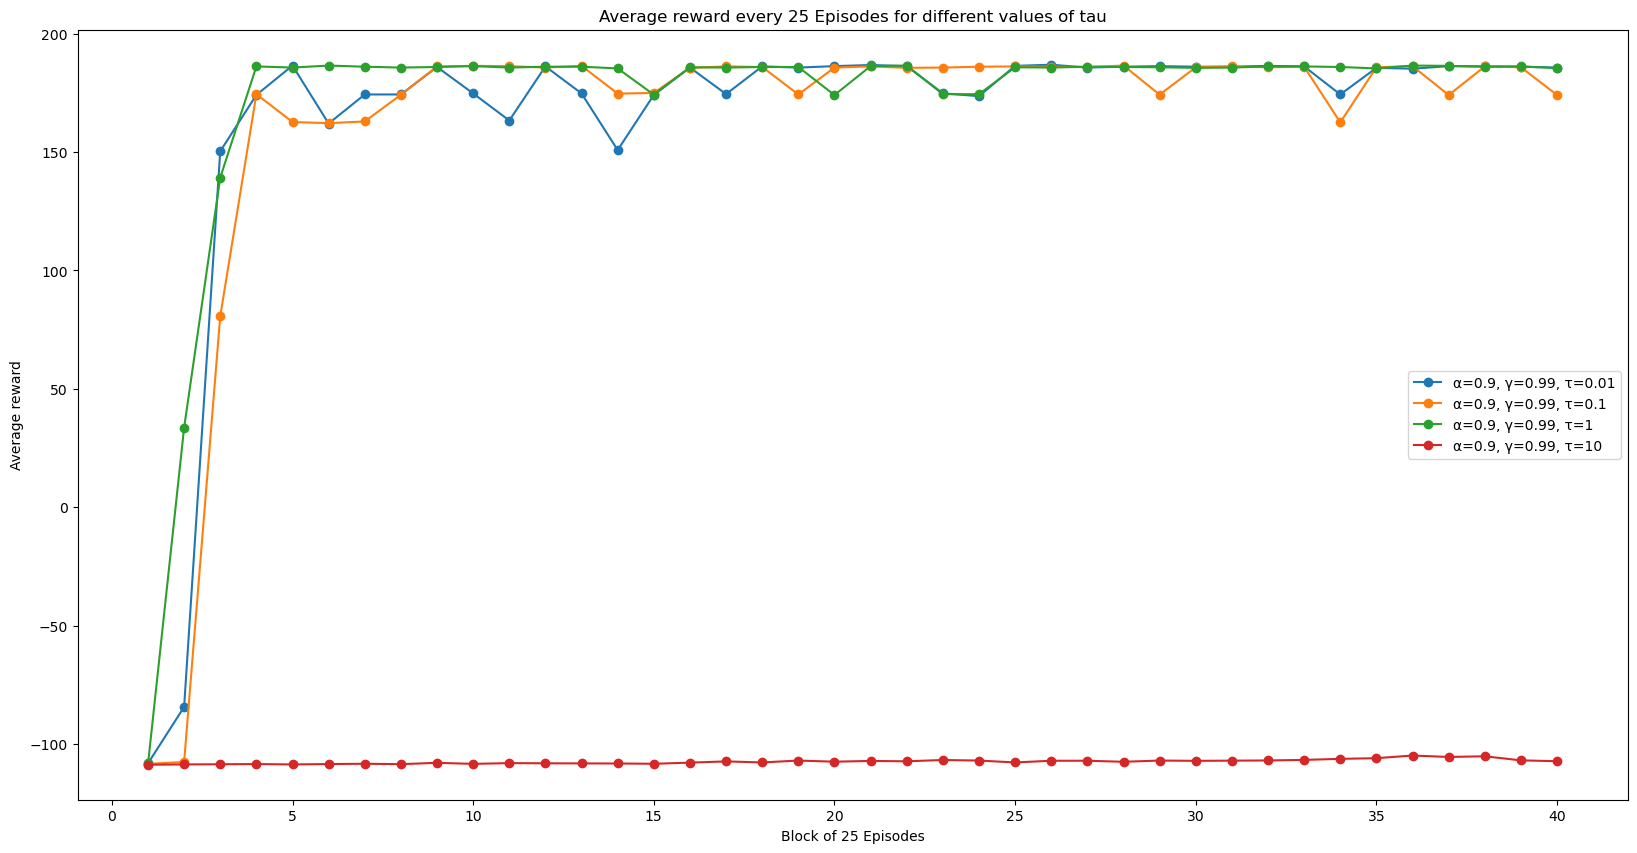

In [42]:
plt.figure(figsize=(20,10))

for tau in tau_values:
    #compute the qlearning function defined above
    _, episode_rewards = q_learning_softmax(env, episodes=1000, alpha=alpha, gamma=gamma, tau=tau)
    #Get the mean reward block by block 
    block_size = 25
    number_blocks = len(episode_rewards) // block_size
    mean_rewards = []
    for i in range(number_blocks):
        block_reward = np.mean(episode_rewards[i * block_size:(i + 1) * block_size])
        mean_rewards.append(block_reward)
            
    #plot the reward for each block
    plt.plot(range(1, number_blocks + 1), mean_rewards, marker='o', linestyle='-', label=f'α={alpha}, γ={gamma}, τ={tau}') #Used a LLM for this plot because i couldn't find the greek letters properly

#plot
plt.title('Average reward every 25 Episodes for different values of tau')
plt.xlabel('Block of 25 Episodes')
plt.ylabel('Average reward')
plt.legend()
plt.show()

ADVANCED TASKS

In [ ]:
import torch
from torch import nn

#Synchronizing two networks for Double Q-learning, improvement 
#q_network_1 is the first model
#q_network_2 is the second one from which we will get weights
def synchronize_q_networks(q_network_1: nn.Module, q_network_2: nn.Module) -> None:
    """In place, synchronization of q_network_1 and q_network_2."""
    _ = q_network_1.load_state_dict(q_network_2.state_dict())


#Get the action with highest value for each state, following a greedy policy
def select_greedy_actions(states: torch.Tensor, q_network: nn.Module) -> torch.Tensor:
    """Select the greedy action for the current state given some Q-network."""
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions

# compute the q-value for given actions
def evaluate_selected_actions(states: torch.Tensor,
                              actions: torch.Tensor,
                              rewards: torch.Tensor,
                              dones: torch.Tensor,
                              gamma: float,
                              q_network: nn.Module) -> torch.Tensor:
    """Compute the Q-values by evaluating the actions given the current states and Q-network."""
    next_q_values = q_network(states).gather(dim=1, index=actions)        
    q_values = rewards + (gamma * next_q_values * (1 - dones))
    return q_values

#One network selects actions, the other one evaluates them
def double_q_learning_update(states: torch.Tensor,
                             rewards: torch.Tensor,
                             dones: torch.Tensor,
                             gamma: float,
                             q_network_1: nn.Module,
                             q_network_2: nn.Module) -> torch.Tensor:
    """Double Q-Learning uses Q-network 1 to select actions and Q-network 2 to evaluate the selected actions."""
    actions = select_greedy_actions(states, q_network_1)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network_2)
    return q_values

#Gets the difference between expected and obtained q-values, to update the network
def double_q_learning_error(states: torch.Tensor,
                            actions: torch.Tensor,
                            rewards: torch.Tensor,
                            next_states: torch.Tensor,
                            dones: torch.Tensor,
                            gamma: float,
                            q_network_1: nn.Module,
                            q_network_2: nn.Module) -> torch.Tensor:
    expected_q_values = double_q_learning_update(next_states, rewards, dones, gamma, q_network_1, q_network_2)
    q_values = q_network_1(states).gather(dim=1, index=actions)
    delta = expected_q_values - q_values
    return delta

In [ ]:
import collections
import typing

import numpy as np


_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names) #tuple for an agent experience

#class to store experience
class PrioritizedExperienceReplayBuffer:
    """Fixed-size buffer to store priority, Experience tuples."""

    def __init__(self,
                 batch_size: int,
                 buffer_size: int,
                 alpha: float = 0.0,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.

        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        alpha (float): Strength of prioritized sampling. Default to 0.0 (i.e., uniform sampling).
        random_state (np.random.RandomState): random number generator.
        
        """
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer_length = 0 # current number of prioritized experience tuples in buffer
        self._buffer = np.empty(self._buffer_size, dtype=[("priority", np.float32), ("experience", Experience)])
        self._alpha = alpha
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        """Current number of prioritized experience tuple stored in buffer."""
        return self._buffer_length

    @property
    def alpha(self):
        """Strength of prioritized sampling."""
        return self._alpha

    @property
    def batch_size(self) -> int:
        """Number of experience samples per training batch."""
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        """Maximum number of prioritized experience tuples stored in buffer."""
        return self._buffer_size

#Adds a new exp to the buffer
    def add(self, experience: Experience) -> None:
        """Add a new experience to memory."""
        priority = 1.0 if self.is_empty() else self._buffer["priority"].max()
        if self.is_full():
            if priority > self._buffer["priority"].min():
                idx = self._buffer["priority"].argmin()
                self._buffer[idx] = (priority, experience)
            else:
                pass # low priority experiences should not be included in buffer
        else:
            self._buffer[self._buffer_length] = (priority, experience)
            self._buffer_length += 1

    def is_empty(self) -> bool:
        """True if the buffer is empty; False otherwise."""
        return self._buffer_length == 0
    
    def is_full(self) -> bool:
        """True if the buffer is full; False otherwise."""
        return self._buffer_length == self._buffer_size
    
    def sample(self, beta: float) -> typing.Tuple[np.array, np.array, np.array]:
        """Sample a batch of experiences from memory."""
        # use sampling scheme to determine which experiences to use for learning
        ps = self._buffer[:self._buffer_length]["priority"]
        sampling_probs = ps**self._alpha / np.sum(ps**self._alpha)
        idxs = self._random_state.choice(np.arange(ps.size),
                                         size=self._batch_size,
                                         replace=True,
                                         p=sampling_probs)
        
        # select the experiences and compute sampling weights
        experiences = self._buffer["experience"][idxs]        
        weights = (self._buffer_length * sampling_probs[idxs])**-beta
        normalized_weights = weights / weights.max()
        
        return idxs, experiences, normalized_weights

#Updated the priorities of given xp based on data
    def update_priorities(self, idxs: np.array, priorities: np.array) -> None:
        """Update the priorities associated with particular experiences."""
        self._buffer["priority"][idxs] = priorities

In [ ]:
import typing

import numpy as np
import torch
from torch import nn, optim


A = typing.TypeVar('A', bound='Agent')

#Basic class to define an agent
class Agent:
    
    def choose_action(self, state: np.array) -> int:
        """Rule for choosing an action given the current state of the environment."""
        raise NotImplementedError
        
    def learn(self, experiences: typing.List[Experience]) -> None:
        """Update the agent's state based on a collection of recent experiences."""
        raise NotImplementedError

    def save(self, filepath) -> None:
        """Save any important agent state to a file."""
        raise NotImplementedError
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """Update agent's state after observing the effect of its action on the environment."""
        raise NotImplmentedError


class DeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 number_hidden_units: int,
                 optimizer_fn: typing.Callable[[typing.Iterable[nn.Parameter]], optim.Optimizer],
                 batch_size: int,
                 buffer_size: int,
                 alpha: float,
                 beta_annealing_schedule: typing.Callable[[int], float],
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 gamma: float,
                 update_frequency: int,
                 seed: int = None) -> None:
        """
        Initialize a DeepQAgent.
        
        Parameters:
        -----------
        state_size (int): the size of the state space.
        action_size (int): the size of the action space.
        number_hidden_units (int): number of units in the hidden layers.
        optimizer_fn (callable): function that takes Q-network parameters and returns an optimizer.
        batch_size (int): number of experience tuples in each mini-batch.
        buffer_size (int): maximum number of experience tuples stored in the replay buffer.
        alpha (float): Strength of prioritized sampling; alpha >= 0.0.
        beta_annealing_schedule (callable): function that takes episode number and returns beta >= 0.
        epsilon_decay_schdule (callable): function that takes episode number and returns 0 <= epsilon < 1.
        alpha (float): rate at which the target q-network parameters are updated.
        gamma (float): Controls how much that agent discounts future rewards (0 < gamma <= 1).
        update_frequency (int): frequency (measured in time steps) with which q-network parameters are updated.
        seed (int): random seed
        
        """
        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
        # initialize agent hyperparameters
        _replay_buffer_kwargs = {
            "alpha": alpha,
            "batch_size": batch_size,
            "buffer_size": buffer_size,
            "random_state": self._random_state
        }
        self._memory = PrioritizedExperienceReplayBuffer(**_replay_buffer_kwargs)
        self._beta_annealing_schedule = beta_annealing_schedule
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._gamma = gamma
        
        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._online_q_network = self._initialize_q_network(number_hidden_units)
        self._target_q_network = self._initialize_q_network(number_hidden_units)
        synchronize_q_networks(self._target_q_network, self._online_q_network)        
        self._online_q_network.to(self._device)
        self._target_q_network.to(self._device)
        
        #initialize the optimizer
        self._optimizer = optimizer_fn(self._online_q_network.parameters())

        #initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0

    #feedforward nn, with relu activation function, aimed to approximate qvalue function 
    def _initialize_q_network(self, number_hidden_units: int) -> nn.Module:
        """Create a neural network for approximating the action-value function."""
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=self._action_size)
        )
        return q_network
    #Selects a random action uniformly      
    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._action_size)
    
    #Selects action with highest q-value (greedy)    
    def _greedy_policy(self, state: torch.Tensor) -> int:
        """Choose an action that maximizes the action_values given the current state."""
        actions = select_greedy_actions(state, self._online_q_network)
        action = (actions.cpu()  # actions might reside on the GPU!
                         .item())
        return action
    
    #epsilon greedy policy
    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        """With probability epsilon explore randomly; otherwise exploit knowledge optimally."""
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action
    
    #Choose an action given one of the policies defined above
    def choose_action(self, state: np.array) -> int:
        """
        Return the action for given state as per current policy.
        
        Parameters:
        -----------
        state (np.array): current state of the environment.
        
        Return:
        --------
        action (int): an integer representing the chosen action.

        """
        # need to reshape state array and convert to tensor
        state_tensor = (torch.from_numpy(state)
                             .unsqueeze(dim=0)
                             .to(self._device))
            
        # choose uniform at random if agent has insufficient experience
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(state_tensor)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(state_tensor, epsilon)
        return action
    
    #get experience to update parameters of the q-network
    def learn(self, idxs: np.array, experiences: np.array, sampling_weights: np.array) -> None:
        """Update the agent's state based on a collection of recent experiences."""
        states, actions, rewards, next_states, dones = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))
        
        # need to add second dimension to some tensors
        actions = (actions.long()
                          .unsqueeze(dim=1))
        rewards = rewards.unsqueeze(dim=1)
        dones = dones.unsqueeze(dim=1)
        
        deltas = double_q_learning_error(states,
                                         actions,
                                         rewards,
                                         next_states,
                                         dones,
                                         self._gamma,
                                         self._online_q_network,
                                         self._target_q_network)
        
        # update experience priorities
        priorities = (deltas.abs()
                            .cpu()
                            .detach()
                            .numpy()
                            .flatten())
        self._memory.update_priorities(idxs, priorities + 1e-6) # priorities must be positive!
        
        # compute the mean squared loss
        _sampling_weights = (torch.Tensor(sampling_weights)
                                  .view((-1, 1)))
        loss = torch.mean((deltas * _sampling_weights)**2)
        
        # updates the parameters of the online network
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        
        synchronize_q_networks(self._target_q_network, self._online_q_network)
    
    def has_sufficient_experience(self) -> bool:
        """True if agent has enough experience to train on a batch of samples; False otherwise."""
        return len(self._memory) >= self._memory.batch_size
    
    def save(self, filepath: str) -> None:
        """
        Saves the state of the DeepQAgent.
        
        Parameters:
        -----------
        filepath (str): filepath where the serialized state should be saved.
        
        Notes:
        ------
        The method uses `torch.save` to serialize the state of the q-network, 
        the optimizer, as well as the dictionary of agent hyperparameters.
        
        """
        checkpoint = {
            "q-network-state": self._online_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "agent-hyperparameters": {
                "alpha": self._memory.alpha,
                "beta_annealing_schedule": self._beta_annealing_schedule,
                "batch_size": self._memory.batch_size,
                "buffer_size": self._memory.buffer_size,
                "epsilon_decay_schedule": self._epsilon_decay_schedule,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency
            }
        }
        torch.save(checkpoint, filepath)
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """
        Updates the agent's state based on feedback received from the environment.
        
        Parameters:
        -----------
        state (np.array): the previous state of the environment.
        action (int): the action taken by the agent in the previous state.
        reward (float): the reward received from the environment.
        next_state (np.array): the resulting state of the environment following the action.
        done (bool): True is the training episode is finised; false otherwise.
        
        """
        experience = Experience(state, action, reward, next_state, done)
        self._memory.add(experience) 
            
        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1
            
            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                beta = self._beta_annealing_schedule(self._number_episodes)
                idxs, experiences, sampling_weights = self._memory.sample(beta)
                self.learn(idxs, experiences, sampling_weights)

In [ ]:
import collections
import typing

# import gym
import gymnasium as gym

#function to train the agent, with max number of timesteps
def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> int:
    """Train agent for a maximum number of timesteps."""
    state = env.reset()
    score = 0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, done, truncate, info = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score

#Train the agent but without max number of timesteps                
def _train_until_done(agent: Agent, env: gym.Env) -> float:
    """Train the agent until the current episode is complete."""
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
    return score

#train the agent normally
def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    """
    Reinforcement learning training loop.
    
    Parameters:
    -----------
    agent (Agent): an agent to train.
    env (gym.Env): an environment in which to train the agent.
    checkpoint_filepath (str): filepath used to save the state of the trained agent.
    number_episodes (int): maximum number of training episodes.
    maximum_timesteps (int): maximum number of timesteps per episode.
    
    Returns:
    --------
    scores (list): collection of episode scores from training.
    
    """
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score = _train_until_done(agent, env)
        else:
            score = _train_for_at_most(agent, env, maximum_timesteps)         
        scores.append(score)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        if (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores

In [ ]:
import gym

env = gym.make('LunarLander-v2')
_ = env.seed(42)

In [ ]:
#get a constant value no matter the number of episodes
def constant_annealing_schedule(n, constant):
    return constant

# get a value that changes exponentially over episodes
def exponential_annealing_schedule(n, rate):
    return 1 - np.exp(-rate * n)

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10,6))
ns = np.arange(2000)
rate = 1e-2
_ = ax.plot(ns, exponential_annealing_schedule(ns, rate))
_ = ax.set_ylabel(r"$\beta$", rotation="horizontal", fontsize=20)
_ = ax.set_xlabel("Number of Episodes", fontsize=15)
_ = ax.set_title(r"Typical $\beta$ annealing schedule", fontsize=15)

In [ ]:
#Calculate how much a parameter value decays over episodes
def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

#useful to use param without calling them specifically
_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.99,
    "minimum_epsilon": 1e-2,
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

In [ ]:
from torch import optim

#hyperparameters for adam optimizer
_optimizer_kwargs = {
    "lr": 1e-3,
    "betas":(0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **_optimizer_kwargs)

In [ ]:
#gets the parameters for our DQagent with alpha = 0, uniform sampling 
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "alpha": 0.0,
    "batch_size": 64,
    "buffer_size": 100000,
    "beta_annealing_schedule": lambda n: constant_annealing_schedule(n, 0.0),
    "gamma": 0.99,
    "update_frequency": 4,
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

uniform_sampling_scores = train(double_dqn_agent,
                                env,
                                "uniform-sampling-checkpoint.pth",
                                number_episodes=2000,
                                target_score=float("inf"))

In [ ]:
##gets the parameters for our DQagent with alpha = 0.5, priotirized replay
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "alpha": 0.5,
    "batch_size": 64,
    "buffer_size": 100000,
    "beta_annealing_schedule": lambda n: exponential_annealing_schedule(n, 1e-2),
    "gamma": 0.99,
    "update_frequency": 4,
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

prioritized_sampling_scores = train(double_dqn_agent,
                                    env,
                                    "prioritized-sampling-checkpoint.pth",
                                    number_episodes=2000,
                                    target_score=float("inf"))

In [ ]:
import pandas as pd

uniform_sampling_scores = pd.Series(uniform_sampling_scores, name="scores")
prioritized_sampling_scores = pd.Series(prioritized_sampling_scores, name="scores")

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = uniform_sampling_scores.plot(ax=axes[0], label="Uniform Sampling")
_ = (uniform_sampling_scores.rolling(window=100)
               .mean()
               .rename("Rolling Average")
               .plot(ax=axes[0]))
_ = axes[0].legend()
_ = axes[0].set_ylabel("Score")

_ = prioritized_sampling_scores.plot(ax=axes[1], label="Double DQN Scores")
_ = (prioritized_sampling_scores.rolling(window=100)
                      .mean()
                      .rename("Rolling Average")
                      .plot(ax=axes[1]))
_ = axes[1].legend()
_ = axes[1].set_ylabel("Score")
_ = axes[1].set_xlabel("Episode Number")

In [ ]:
fig, ax = plt.subplots(1,1)
_ = uniform_sampling_scores.plot(kind="kde", ax=ax, label="Uniform Sampling")
_ = prioritized_sampling_scores.plot(kind="kde", ax=ax, label="Priority Sampling")
_ = ax.set_xlabel("Score")
_ = ax.set_xscale("symlog")
_ = ax.legend()